Import required Libraries

In [1]:
import os
import sys
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2

In [2]:
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0,rpath)
from src import utils
from src.plots import Plot
from src.preprocess import PreProcess
from src.overview import Overview

In [3]:
df = pd.read_csv('../data/cleaned_data_outliers.csv')

In [4]:
plots = Plot()
preprocess = PreProcess(df)
overview = Overview(df)

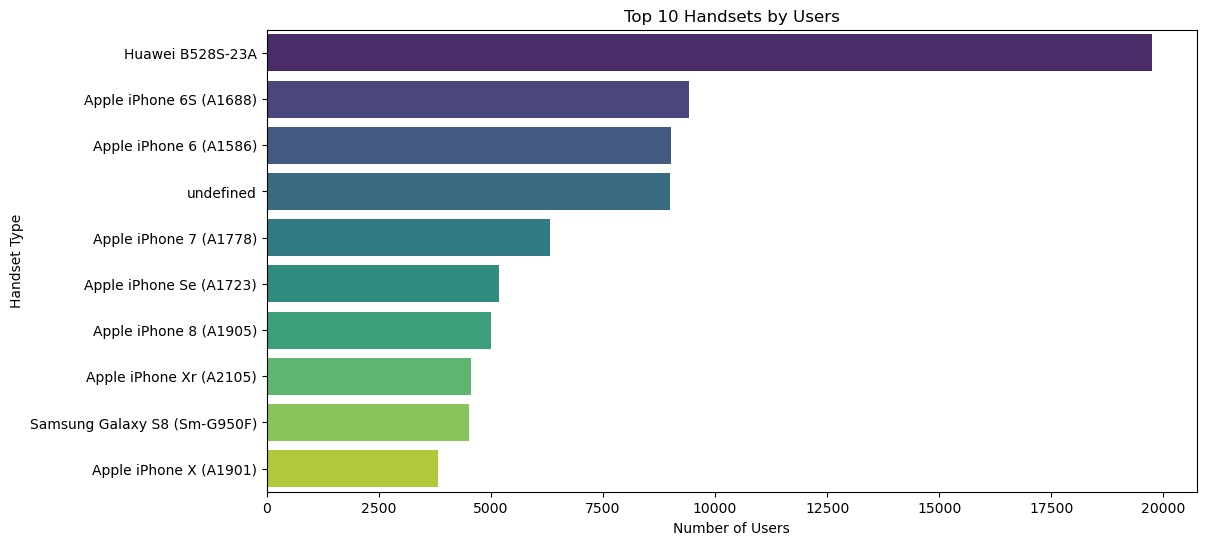

In [5]:
#Identify top 10 handsets used by the customers
handset_counts = df['Handset Type'].value_counts().head(10)
plots.plot_bar(x=handset_counts.values, y=handset_counts.index, xlabel='Number of Users', title='Top 10 Handsets by Users',ylabel='Handset Type')

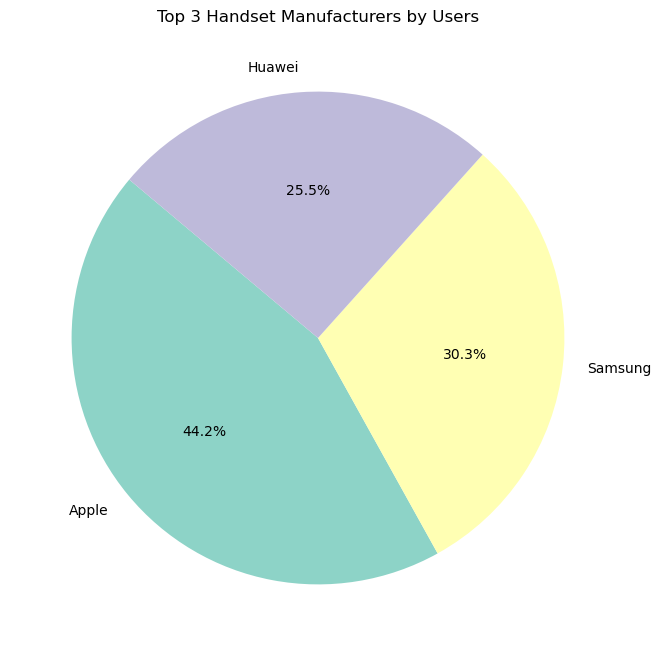

In [6]:
manufacturer_counts = df['Handset Manufacturer'].value_counts().head(3)
plots.plot_pie(manufacturer_counts, title='Top 3 Handset Manufacturers by Users')

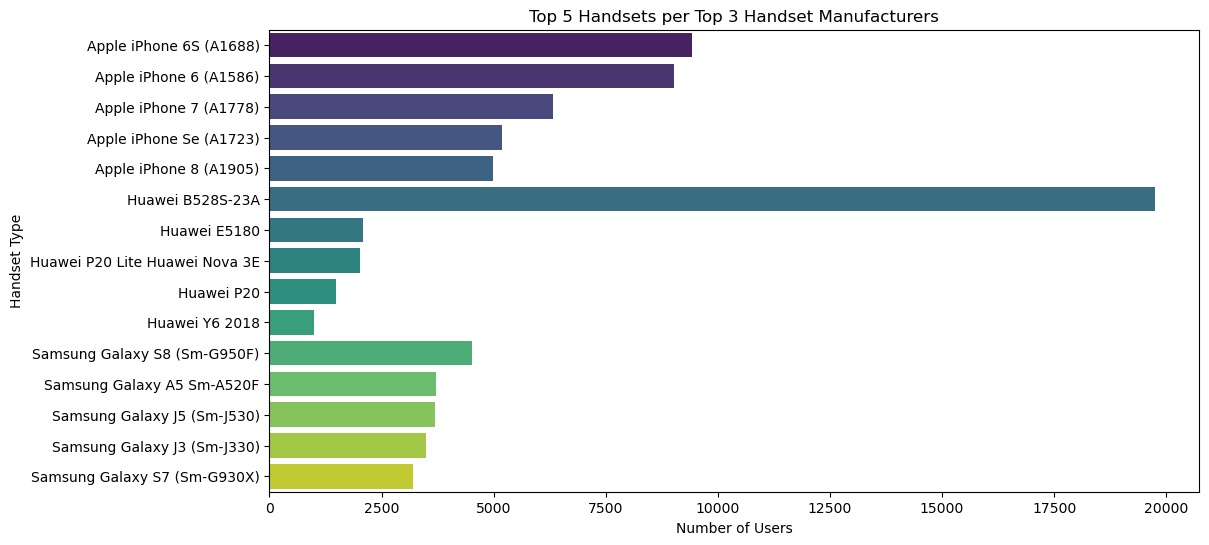

In [7]:
top_manufacturers = df['Handset Manufacturer'].value_counts().head(3).index

# Filter the DataFrame to include only the top 3 manufacturers
df_top_manufacturers = df[df['Handset Manufacturer'].isin(top_manufacturers)]

# Get the top 5 handsets for each manufacturer
top_handsets_per_manufacturer = (
    df_top_manufacturers
    .groupby('Handset Manufacturer')['Handset Type']
    .value_counts()
    .groupby(level=0, group_keys=False)
    .nlargest(5)
    .reset_index(name='Count')
)

plots.plot_bar(x=top_handsets_per_manufacturer['Count'], y=top_handsets_per_manufacturer['Handset Type'], xlabel='Number of Users', title='Top 5 Handsets per Top 3 Handset Manufacturers',ylabel='Handset Type',palette='viridis')


In [8]:
# Group by User and calculate the number of sessions
xDR_sess_agg = df['MSISDN/Number'].value_counts()
print(xDR_sess_agg.nlargest(10))

MSISDN/Number
3.362632e+10    18
3.361489e+10    17
3.362578e+10    17
3.365973e+10    16
3.376054e+10    15
3.367588e+10    15
3.366716e+10    13
3.360313e+10    12
3.378632e+10    12
3.376041e+10    12
Name: count, dtype: int64


In [9]:
df.groupby('MSISDN/Number')['Dur. (ms)'].sum().nlargest(10)

MSISDN/Number
3.362578e+10    233.413129
3.362632e+10    231.977427
3.361489e+10    222.446521
3.365973e+10    198.016024
3.376054e+10    195.767900
3.367588e+10    188.665113
3.366716e+10    172.629643
3.360313e+10    156.933829
3.360452e+10    154.378835
3.376041e+10    154.085482
Name: Dur. (ms), dtype: float64

In [10]:
#  total download (DL) 
df.groupby('MSISDN/Number')[['Total DL (Bytes)', 'Total UL (Bytes)']].sum().nlargest(10, 'Total DL (Bytes)')

,Total DL (Bytes),Total UL (Bytes)
MSISDN/Number,,
3.362632e+10,354.469774,313.238174
3.361489e+10,336.610039,296.955644
3.362578e+10,336.420166,298.278567
3.365973e+10,313.799886,279.152641
3.367588e+10,297.810275,261.389693
3.376054e+10,297.518869,264.702722
3.366716e+10,254.286268,228.070512
3.376041e+10,239.418673,210.802513
3.362708e+10,236.605837,208.397906


In [11]:
df["social_media"] = df["Social Media DL (Bytes)"] + df['Social Media UL (Bytes)']
df["google"] = df["Google DL (Bytes)"] + df["Google UL (Bytes)"]
df['email'] = df["Email DL (Bytes)"] + df["Email UL (Bytes)"]
df['youtube'] = df["Youtube DL (Bytes)"] + df["Youtube UL (Bytes)"]
df['netflix'] = df["Netflix DL (Bytes)"] + df["Netflix UL (Bytes)"]
df["gaming"] = df["Gaming DL (Bytes)"] + df["Gaming UL (Bytes)"]
df['other'] = df["Other DL (Bytes)"]+df["Other UL (Bytes)"]
df['total_data'] = df['Total DL (Bytes)'] + df['Total UL (Bytes)']

#### Interpretation and recommendation to marketing teams

Based on the above analysis, The following is recommended:
As most of the users are using devices from Manufacturers of Apple, Samsung, and Huawei, the sales team should focus on these product owners.
Customers' best-performing devices might be promoted by the marketing team. Huawei may be considered for a cross promotion due to their products holding the most slots in the top ten handsets. Samsung and Apple are also considered for cross promotion.

In [12]:
quantitative_vars = df.select_dtypes(include=['float64', 'int64'])

# Calculate dispersion parameters
dispersion_parameters = pd.DataFrame({
    'Mean': quantitative_vars.mean(),
    'Std Deviation': quantitative_vars.std(),
    'Min': quantitative_vars.min(),
    '25th Percentile (Q1)': quantitative_vars.quantile(0.25),
    'Median (Q2)': quantitative_vars.median(),
    '75th Percentile (Q3)': quantitative_vars.quantile(0.75),
    'Max': quantitative_vars.max(),
    'IQR': quantitative_vars.quantile(0.75) - quantitative_vars.quantile(0.25)
})

# Display the results
print(dispersion_parameters)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


                                                  Mean  Std Deviation  \
Bearer Id                                 1.013887e+19   2.893173e+18   
Start ms                                  4.991882e+02   2.886118e+02   
End ms                                    4.988009e+02   2.880977e+02   
Dur. (ms)                                 1.131559e+01   7.289601e-01   
IMSI                                      3.296953e+01   1.030171e-04   
MSISDN/Number                             4.188282e+10   2.447443e+12   
IMEI                                      4.847455e+13   2.241637e+13   
Avg RTT DL (ms)                                   -inf            NaN   
Avg RTT UL (ms)                                   -inf            NaN   
Avg Bearer TP DL (kbps)                           -inf            NaN   
Avg Bearer TP UL (kbps)                           -inf            NaN   
TCP DL Retrans. Vol (Bytes)               1.274566e+01   3.326952e+00   
TCP UL Retrans. Vol (Bytes)               9.929537e

/opt/homebrew/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [13]:
# Calculate the correlation coefficients
correlation_coefficients = quantitative_vars.corr(method='pearson')
correlation_coefficients

,Bearer Id,Start ms,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),...,Total UL (Bytes),Total DL (Bytes),social_media,google,email,youtube,netflix,gaming,other,total_data
Bearer Id,1.000000,0.002961,-0.001219,0.012184,0.000204,-0.003307,0.164054,0.067067,0.263164,0.067973,...,-0.004271,0.000594,-0.003346,-0.000936,0.001905,-0.001119,-0.002798,-0.001663,-0.000518,-0.001037
Start ms,0.002961,1.000000,0.120945,0.001753,-0.000012,-0.001021,-0.001133,0.000574,0.001387,-0.002709,...,0.000467,-0.004354,-0.000605,0.001584,-0.001588,0.000777,-0.002695,-0.004806,-0.000233,-0.003873
End ms,-0.001219,0.120945,1.000000,-0.001697,0.000308,-0.001890,-0.000032,-0.002869,-0.005008,0.001014,...,-0.000777,-0.005516,-0.001007,0.000854,-0.002109,-0.004089,0.004999,-0.003019,0.002661,-0.005415
Dur. (ms),0.012184,0.001753,-0.001697,1.000000,-0.003886,0.009309,0.011620,-0.198275,-0.079459,-0.315075,...,-0.001449,0.001611,-0.003598,-0.002860,0.001707,0.002764,-0.006668,0.001941,0.002379,0.000958
IMSI,0.000204,-0.000012,0.000308,-0.003886,1.000000,-0.662640,-0.000624,0.000469,-0.004686,-0.000054,...,0.000519,0.005267,-0.001813,-0.004056,-0.001932,0.001694,-0.001963,0.003228,-0.000166,0.005088
MSISDN/Number,-0.003307,-0.001021,-0.001890,0.009309,-0.662640,1.000000,0.005703,0.019747,0.052152,-0.005371,...,0.004503,-0.004419,0.000699,0.002372,0.003081,0.004080,0.002122,-0.002010,0.000930,-0.002430
IMEI,0.164054,-0.001133,-0.000032,0.011620,-0.000624,0.005703,1.000000,0.140492,0.455955,0.368482,...,-0.000716,0.000477,-0.002804,0.000159,0.000284,-0.002187,-0.003642,0.001431,0.004296,0.000177
Avg RTT DL (ms),0.067067,0.000574,-0.002869,-0.198275,0.000469,0.019747,0.140492,1.000000,0.286702,0.302337,...,-0.000193,0.002143,-0.000135,0.003177,-0.001860,0.003688,-0.002462,-0.000261,-0.000048,0.001920
Avg RTT UL (ms),0.263164,0.001387,-0.005008,-0.079459,-0.004686,0.052152,0.455955,0.286702,1.000000,0.530241,...,0.004571,0.000511,-0.005901,-0.001944,-0.000165,-0.000278,0.002988,0.002063,0.003814,0.002177
Avg Bearer TP DL (kbps),0.067973,-0.002709,0.001014,-0.315075,-0.000054,-0.005371,0.368482,0.302337,0.530241,1.000000,...,0.002459,-0.003781,0.000130,-0.000478,-0.002126,0.000469,0.006291,-0.000568,0.003557,-0.002599


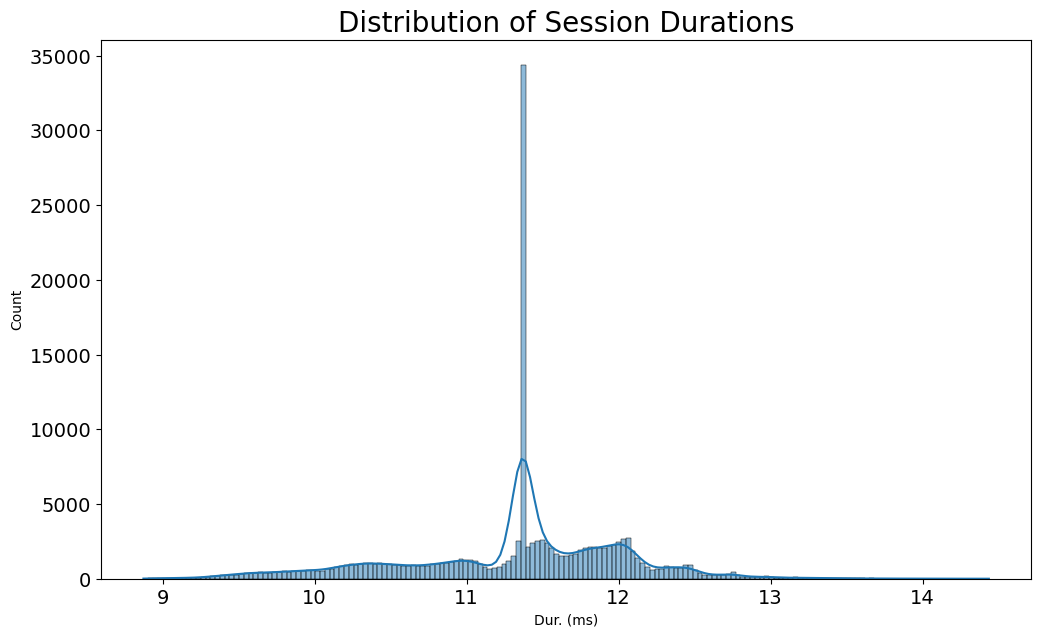

In [17]:
plots.plot_hist(df=df, column='Dur. (ms)', title='Distribution of Session Durations')

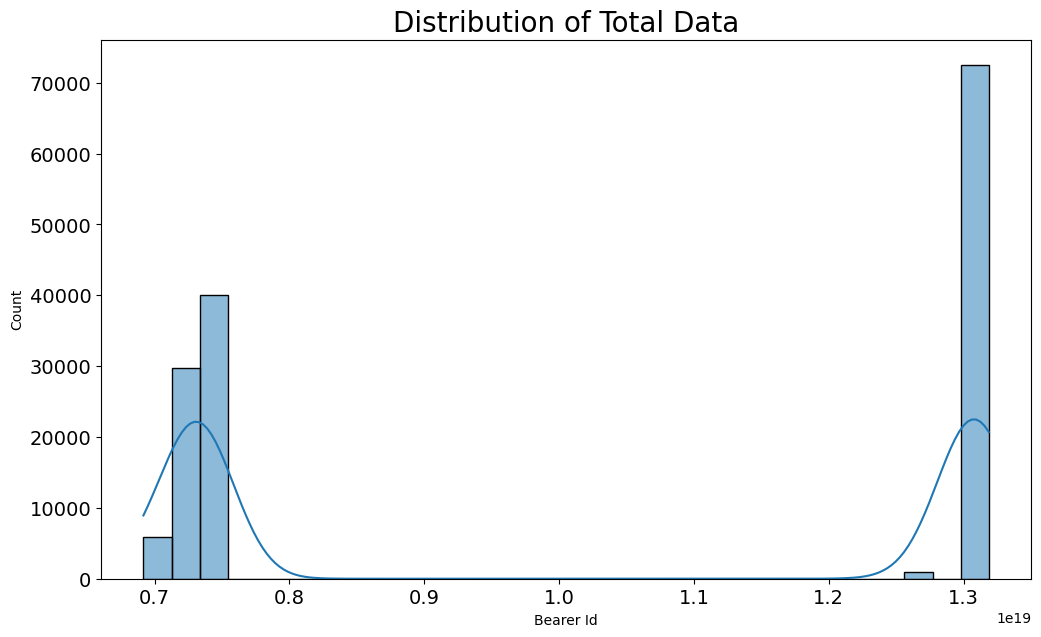

In [19]:
plots.plot_hist(df=df, column='Bearer Id', title='Distribution of Total Data')

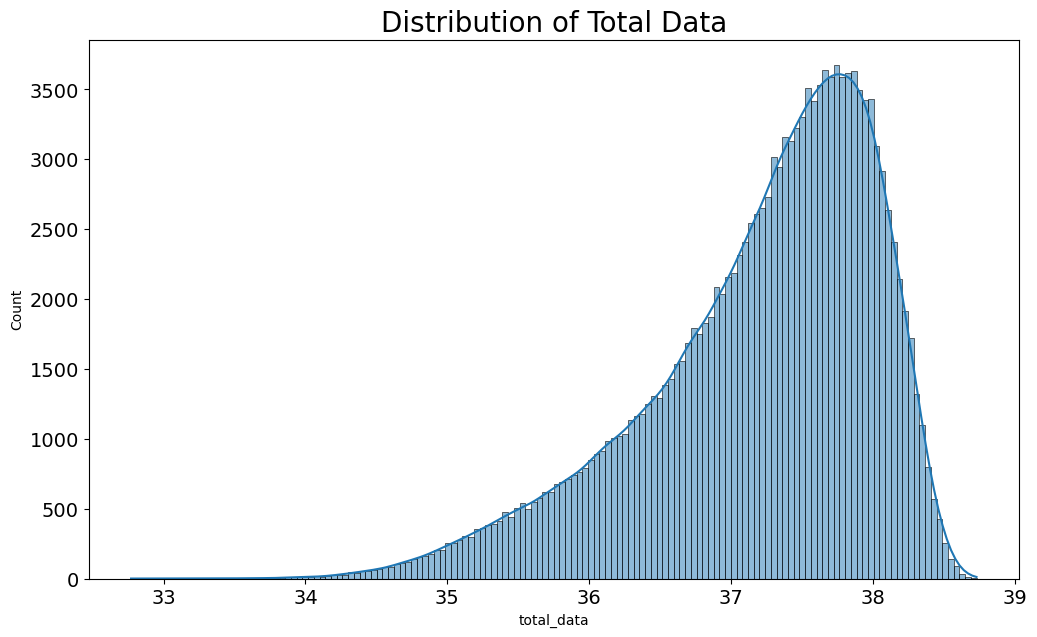

In [21]:
plots.plot_hist(df=df, column='total_data',title='Distribution of Total Data')

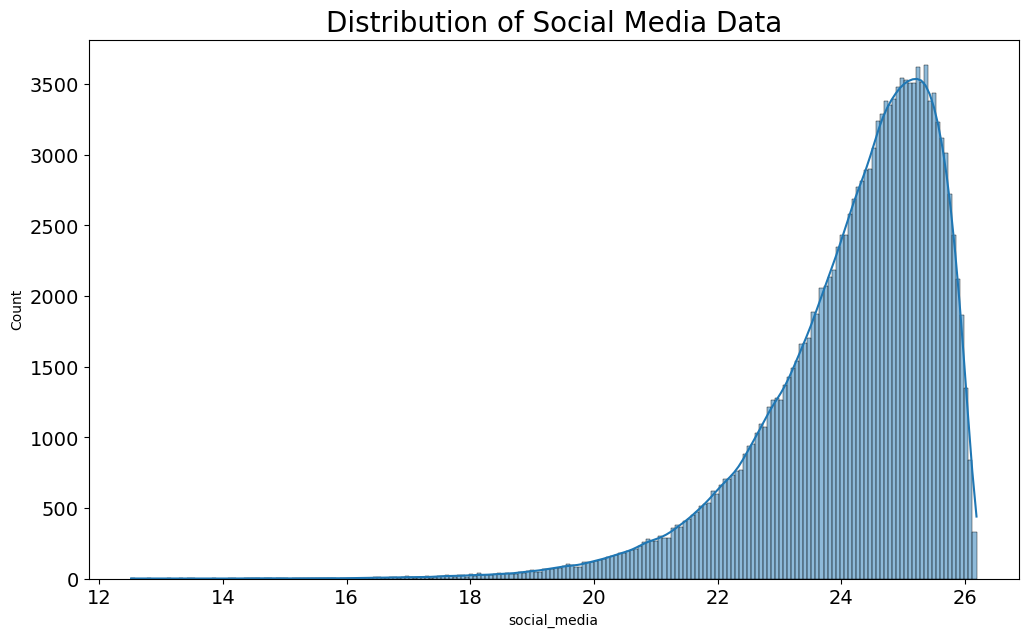

In [23]:
plots.plot_hist(df=df, column='social_media', title='Distribution of Social Media Data')